# RDD Implementation

## Importing and creating the Spark session

In [2]:
from sklearn.datasets import fetch_kddcup99
from pyspark.sql import SparkSession
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import time

npr.seed(536453550)
spark_seed = 80553771

In [3]:
spark = SparkSession.builder \
    .master("spark://localhost:7077") \
    .appName("k-meaner") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

23/07/16 18:34:43 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
!pip install scikit-learn

from sklearn.datasets import fetch_kddcup99
from pyspark.sql import SparkSession
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("k-meaner") \
    .config("spark.executor.memory", "512m") \
    .getOrCreate()

sc = spark.sparkContext

sc.setLogLevel("ERROR")
npr.seed(536453550)
spark_seed = 80553771


Defaulting to user installation because normal site-packages is not writeable


## Loading the `kddcup99` dataset
We will load the entire dataset, without filtering.

In [5]:
kdd = fetch_kddcup99(return_X_y=True)
n_samples = kdd[0].shape[0]
print(f"Number of samples: {n_samples}")

Number of samples: 494021


`kdd` is a tuple where the first element is an array of data points, while the second element is filled with the corresponding labels – i.e., the attack types.

In [6]:
kdd

(array([[0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
        ...,
        [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0],
        [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0]], dtype=object),
 array([b'normal.', b'normal.', b'normal.', ..., b'normal.', b'normal.',
        b'normal.'], dtype=object))

In [7]:
labels = kdd[1]

Also, we save the number of unique labels; we will need this later when we choose the number of clusters for the `k-means`.

In [8]:
k = len(set(labels))

Let’s examine the distribution of attack types.

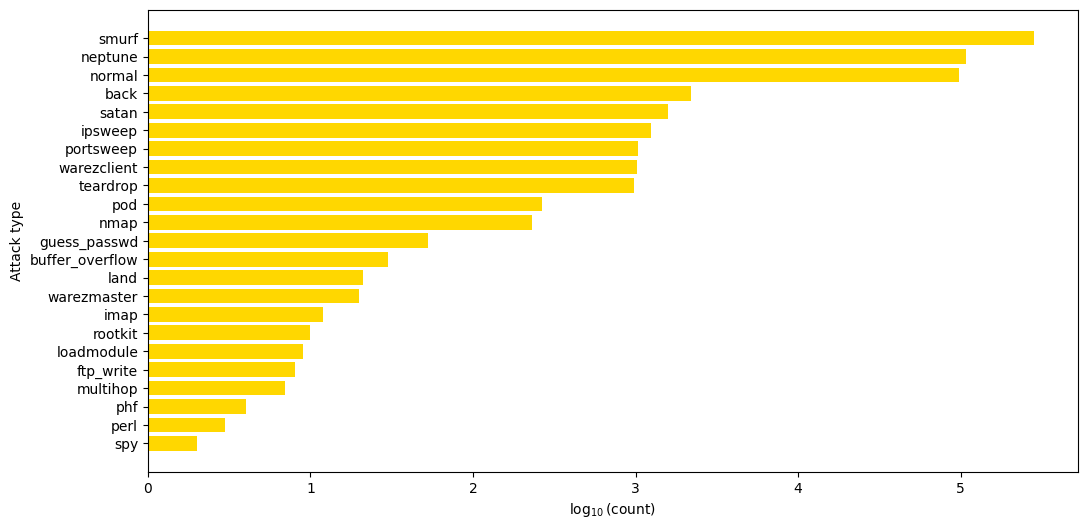

In [9]:
attacks, counts = np.unique(labels, return_counts=True)
ypos = np.arange(len(attacks))

attack_sort = np.argsort(counts)
attacks = attacks[attack_sort]
counts = counts[attack_sort]

plt.figure(figsize=(12, 6))
plt.barh(ypos, np.log10(counts), facecolor="gold")
plt.yticks(ypos, labels=[a.decode("utf-8")[0:-1] for a in attacks])
plt.xlabel(r"$\log_{10}(\mathrm{count})$")
plt.ylabel("Attack type")
plt.show()

## Pre-processing
Let's load the dataset into a PySpark Resilient Distributed Dataset (RDD).
We will keep the same level of parallelization (`n_slices`) for all the RDDs in the analysis. 

In [10]:
data = kdd[0]
n_slices = 16

kdd_rdd = sc.parallelize(
    [(0, {"features": data[i], "label": labels[i]}) for i in range(n_samples)],
    numSlices=n_slices
)

print(kdd_rdd.getNumPartitions())

16


First, we remove the columns of `bytes` type and keep only the numerical ones.

In [11]:
def remove_bytes(x):
    # remove the elements with type 'bytes' (so, keep only the floats)
    mask = [type(i) != bytes for i in x[1]["features"]]
    feat_cut = np.asarray(x[1]["features"][mask], dtype=float)

    return (0, {"features": feat_cut, "label": x[1]["label"]})


kdd_rdd = kdd_rdd.map(remove_bytes)

Now we rescale the remaining columns with their maximum and minimum to fit in the [0, 1] range, since there is a huge variability in the data ranges.

In [12]:
def rescale(x, mins, maxs):
    mask = (mins < maxs).astype(bool)
    # rescale
    features = x[1]["features"]
    features[mask] = (features[mask] - mins[mask]) / (maxs[mask] - mins[mask])
    
    return (0, {"features": features, "label": x[1]["label"]})
    

data_mins = kdd_rdd \
    .map(lambda x: x[1]["features"]) \
    .reduce(lambda x, y: np.minimum(x, y))

data_maxs = kdd_rdd \
    .map(lambda x: x[1]["features"]) \
    .reduce(lambda x, y: np.maximum(x, y))

kdd_rdd = kdd_rdd.map(lambda x: rescale(x, data_mins, data_maxs))

In [13]:
kdd_rdd.take(1)

[(0,
  {'features': array([0.00000000e+00, 2.61041764e-07, 1.05713002e-03, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.56555773e-02,
          1.56555773e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          3.52941176e-02, 3.52941176e-02, 1.00000000e+00, 0.00000000e+00,
          1.10000000e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00]),
   'label': b'normal.'})]

## `k-means` implementation

### Lloyd’s algorithm


In [19]:
def assign_to_cluster(sample, centroids):
    distances = np.sum((sample[1]["features"] - centroids)**2, axis=1) 
    # get the cluster id from the closest centroid
    cluster_id = np.argmin(distances)

    return (cluster_id, sample[1])


def k_means(rdd, centroids, max_iters):
    cost_list = [float("inf")]
    for i in range(max_iters):        
        # find the nearest centroid to each sample
        # and cache the dataset in memory for faster access
        rdd_cached = rdd \
            .map(lambda x: assign_to_cluster(x, centroids)) \
            .persist()
        
        # update the centroids by averaging the points inside
        centroids = rdd_cached \
            .mapValues(lambda x: (x["features"], 1)) \
            .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) \
            .mapValues(lambda x: x[0] / x[1]) \
            .values() \
            .collect()
        
        # compute cost by summing the squared distance to the nearest cluster
        cost = rdd_cached \
            .map(lambda x: np.sum((x[1]["features"] - centroids[x[0]])**2)) \
            .reduce(lambda x, y: x + y)
        
        # break if the new cost doesn't change too much (< 0.1%)
        # w.r.t. the previous iteration
        if cost > 0.999 * cost_list[-1]:
            print(f"Convergence at iteration {i + 1}")
            cost_list.append(cost)
            rdd_cached.unpersist()
            break
        else:
            cost_list.append(cost)
        
        # clear the cache
        rdd_cached.unpersist()
        
    return centroids, cost_list


### Initialization functions
We define the three different initialization functions: *naïve* (i.e. sampling centroids at random from the dataset), *k-means++* and *k-means//*.

In [15]:
def stupid_init(rdd, n_clusters):
    # we have to sample n_clusters *different* points
    ## we can't call .distinct() on the rdd because np.array is not hashable,
    ## so we first add a key with the raw data string of the array and then
    ## "unique-ize" with reduceByKey
    centroids = rdd \
        .map(lambda x: (x[1]["features"].tobytes(), x[1]["features"])) \
        .reduceByKey(lambda x, y: x) \
        .values() \
        .takeSample(withReplacement=False, num=n_clusters, seed=spark_seed)

    return centroids

The k-means++ is an inherently sequential algorithm, so we will implement it locally without PySpark functionalities.

In [16]:
def kplus_init(data, n_clusters):
    centroids = np.empty((n_clusters, data.shape[1]))
    # choose the first centroid at random
    centroids[0] = data[np.random.choice(data.shape[0])]
    
    for i in range(1, n_clusters):
        # evaluate distances from the already chosen centroids 
        # and pick the closest for each data point
        distances = np.min(np.sum((data[:, np.newaxis] - centroids[:i])**2, axis=-1), axis=-1)
        
        # sample the new centroids with prob ~ distances
        distances = distances / np.sum(distances)
        c_idx = npr.choice(np.arange(len(distances)), p=distances)
        centroids[i] = data[c_idx]

    return centroids

In [17]:
def parallel_init(rdd, n_clusters, l, n_iters, verbose=True):
    # persist the rdd in memory
    rdd_cached = rdd.persist()
    
    # pick first centroid at random
    c = rdd_cached \
        .takeSample(withReplacement=False, num=1, seed=spark_seed)[0][1]["features"]
    centroids = [c]
    
    # compute cost to estimate the optimal number of iterations
    cost = rdd_cached \
        .map(lambda x: np.sum((x[1]["features"] - c)**2)) \
        .reduce(lambda x, y: x + y)
    
    if (verbose):
        print(f"\nTheoretical number of iterations: {np.log(cost)}\n")
        
    for i in range(1, n_iters):
        # find the distance from every point to every centroid
        # and select the closest
        distances = rdd_cached \
            .map(lambda x: (
                x[1]["features"],
                np.min(np.sum((x[1]["features"] - centroids)**2), axis=-1)
            )) \
            .persist()
        
        if i > 1: # for the first iteration we already have the cost
            cost = distances \
                .map(lambda x: x[1]) \
                .reduce(lambda x, y: x + y)
    
        # sample according to the cost-probability adjusted with
        # the oversampling factor
        c = distances \
            .filter(lambda x: x[1] * l > cost * npr.random()) \
            .map(lambda x: x[0]) \
            .collect()
        centroids += c
        
        distances.unpersist()

    # remove duplicates
    centroids = np.unique(centroids, axis=0)   
    
    if len(centroids) < n_clusters:
        print("Too few centroids sampled, try again with a bigger l...")
        return -1
        
    if len(centroids) > n_clusters:
        bad_centroids = np.array(centroids)

        # assign point to clusters to calculate the populations
        temp_rdd = rdd_cached.map(lambda x: assign_to_cluster(x, bad_centroids))
        populations = np.array(
            [p[1] for p in sorted(temp_rdd.countByKey().items())]
        )

        # k-means++ on centroids to get inits for weighted k-mean
        centroids = kplus_init(bad_centroids, n_clusters)
        
        old_cost = float("Inf")
        for i in range(100): # hopefully you won't ever need 100
            # calculate distances and assign clusters based on them
            distances = np.sum(
                (bad_centroids[:, np.newaxis] - centroids)**2,
                axis=-1
            )
            labels = np.argmin(distances, axis=-1)

            new_cost = 0.0
            for j in range(n_clusters):
                curr_pops = populations[labels == j]
                # update centroids with population-weighted mean
                centroids[j] = np.sum(
                    bad_centroids[labels == j] * curr_pops[:, np.newaxis],
                    axis=0
                ) / np.sum(curr_pops)
                # update cost
                new_cost += np.sum((bad_centroids[labels == j] - centroids[j])**2)
            
            # break if the new cost doesn't change too much (< 1%)
            # w.r.t. the previous iteration
            if (new_cost > 0.99 * old_cost):
                break
            else:
                old_cost = new_cost

    rdd_cached.unpersist() # clear the cache

    return centroids

## Testing (see 3rd notebook for details)

In [20]:
par_c = parallel_init(kdd_rdd, k, 10, 15)


Theoretical number of iterations: 14.1971958819427



In [21]:
par_c = k_means(kdd_rdd, par_c, 15)

In [24]:
par_c

([array([4.20130633e-09, 2.72286838e-05, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 9.07622211e-07, 0.00000000e+00,
         5.44573327e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.36535531e-01,
         2.10026266e-02, 9.99699940e-01, 9.99828732e-01, 1.70179165e-04,
         9.42111855e-05, 9.04852148e-02, 6.48589555e-02, 5.25513260e-05,
         9.98733600e-01, 4.21763499e-02, 4.22376518e-02, 6.41512825e-02,
         2.98698470e-04, 3.21298263e-05, 9.99638676e-01, 9.99776997e-01,
         6.50765126e-05, 9.03991722e-05]),
  array([6.48014048e-04, 7.58611274e-08, 5.96042478e-06, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 3.74393911e-04, 1.80445590e-03,
         3.13017860e-03, 2.08289766e-07, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        

In [22]:
rand_c = stupid_init(kdd_rdd,k)

In [23]:
rand_c = k_means(kdd_rdd, rand_c, 15)

In [25]:
rand_c

([array([4.45915668e-05, 3.69162399e-06, 9.62556863e-05, 0.00000000e+00,
         1.25833648e-04, 0.00000000e+00, 1.09475274e-03, 0.00000000e+00,
         9.68289921e-01, 8.54074533e-06, 0.00000000e+00, 0.00000000e+00,
         6.61482016e-05, 3.64018767e-04, 3.77500944e-04, 1.36844092e-03,
         0.00000000e+00, 0.00000000e+00, 1.51000378e-03, 2.09066080e-03,
         5.04491966e-03, 7.55001888e-04, 2.03850510e-03, 1.88750472e-04,
         4.46961117e-03, 9.86847867e-01, 2.53001133e-02, 9.81619479e-01,
         2.82952501e-01, 4.77430625e-01, 6.71374103e-01, 8.37938845e-02,
         4.35598339e-02, 1.39184598e-02, 2.93318233e-03, 1.72895432e-03,
         8.02189505e-03, 2.23103058e-03]),
  array([1.47609646e-03, 5.44281721e-11, 6.02510555e-08, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         4.39850451e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        

In [23]:
n_iter = 5
u_in = []
u_cl = []
p_in = []
p_cl = []

for i in range(n_iter):
    t1 = time.time()
    rand_c = stupid_init(kdd_rdd,k)
    t2 = time.time()
    u_in.append(t2-t1)
    
    t1=time.time()
    rand_c = k_means(kdd_rdd, rand_c, 15)
    t2 = time.time()
    u_cl.append(t2-t1)
    
    t1=time.time()
    par_c = parallel_init(kdd_rdd, k, 10, 15)
    t2 = time.time()
    p_in.append(t2-t1)
    
    t1=time.time()
    par_c = k_means(kdd_rdd, par_c, 15)
    t2 = time.time()
    p_cl.append(t2-t1)

Convergence at iteration 11



Theoretical number of iterations: 16.819958619875095



Convergence at iteration 7



Theoretical number of iterations: 16.819958619875095



Convergence at iteration 8


Convergence at iteration 13



Theoretical number of iterations: 16.819958619875095



Convergence at iteration 10


Convergence at iteration 13



Theoretical number of iterations: 16.819958619875095



Convergence at iteration 10


Convergence at iteration 13



Theoretical number of iterations: 16.819958619875095



Convergence at iteration 8


In [24]:
u_in

[6.618762731552124,
 12.464976072311401,
 12.385783672332764,
 13.178653240203857,
 12.278600692749023]

In [25]:
u_cl

[147.88093280792236,
 146.70449137687683,
 267.2069208621979,
 269.5066409111023,
 268.15031909942627]

In [28]:
p_in

[198.52358055114746,
 227.87116169929504,
 230.42344212532043,
 213.24074816703796,
 222.1819624900818]

In [27]:
p_cl

[311.72772574424744,
 165.01162958145142,
 206.04673528671265,
 206.08331179618835,
 163.70856761932373]

In [18]:
partitions = [256]
n_cycles = 1
rand = []
par = []

for j in partitions:
    data = kdd[0]
    n_slices = j

    kdd_rdd = sc.parallelize(
        [(0, {"features": data[i], "label": labels[i]}) for i in range(n_samples)],
        numSlices=n_slices
    )
    
    kdd_rdd = kdd_rdd.map(remove_bytes)
    
    data_mins = kdd_rdd \
    .map(lambda x: x[1]["features"]) \
    .reduce(lambda x, y: np.minimum(x, y))

    data_maxs = kdd_rdd \
    .map(lambda x: x[1]["features"]) \
    .reduce(lambda x, y: np.maximum(x, y))

    kdd_rdd = kdd_rdd.map(lambda x: rescale(x, data_mins, data_maxs))

    print(f"Starting partitions: {kdd_rdd.getNumPartitions()}")
    
    for i in range(n_cycles):
        t1 = time.time()
        rand_c = stupid_init(kdd_rdd,k)
        rand_c = k_means(kdd_rdd, rand_c, 15)
        t2 = time.time()
        print(f"Random init, partition size {j}, time {t2-t1}")
        rand.append([j,t2-t1])
    
        t1=time.time()
        par_c = parallel_init(kdd_rdd, k, 10, 15)
        par_c = k_means(kdd_rdd, par_c, 15)
        t2 = time.time()
        print(f"Parallel init, partition size {j}, time {t2-t1}")
        par.append(t2-t1)
        

Starting partitions: 256


Random init, partition size 256, time 492.86563992500305



Theoretical number of iterations: 14.1971958819427



Parallel init, partition size 256, time 782.6229507923126
